In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt 
import math 
import itertools
import networkx as nx


# check folder exist if not create it
def check_exist_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print("Folder created: ", folder_path)
    else:
        print("Folder already exist: ", folder_path)
    return



class Grapher:

    def __init__(self, filename, data_fd):
        self.filename = filename
        self.data_fd = data_fd

        file_path = os.path.join(self.data_fd, "./data_csv_train", filename + '.csv')
        image_path = os.path.join(self.data_fd, "./data_image_train", filename + '.png')
        # print
        # interim_path = os.path.join(self.data_fd, "./", filename + '.csv')
        self.df = pd.read_csv(file_path)
        self.image = cv2.imread(image_path)

    def graph_formation(self, export_graph = False):
        df, image = self.df, self.image
        df.fillna('', inplace=True)

        assert type(df) == pd.DataFrame,f'object_map should be of type \
            {pd.DataFrame}. Received {type(df)}'
        assert type(image) == np.ndarray,f'image should be of type {np.ndarray} \
            . Received {type(image)}'
        
        assert 'xmin' in df.columns, '"xmin" not in object map'
        assert 'xmax' in df.columns, '"xmax" not in object map'
        assert 'ymin' in df.columns, '"ymin" not in object map'
        assert 'ymax' in df.columns, '"ymax" not in object map'
        assert 'Object' in df.columns, '"Object" column not in object map'

        for col in df.columns:
            try:
                df[col] = df[col].str.strip()
            except AttributeError:
                pass
        

        df.dropna(inplace=True) 
        df.sort_values(by=['ymin'], inplace=True)
        df.reset_index(drop=True, inplace=True)

        df["ymax"] = df["ymax"].apply(lambda x: x - 1)
        master = []
        for idx, row in df.iterrows():
            #flatten the nested list 
            flat_master = list(itertools.chain(*master))
            #check to see if idx is in flat_master
            if idx not in flat_master:
                top_a = row['ymin']
                bottom_a = row['ymax']         
                #every line will atleast have the word in it
                line = [idx]         
                for idx_2, row_2 in df.iterrows():
                    #check to see if idx_2 is in flat_master removes ambiguity
                    #picks higher cordinate one. 
                    if idx_2 not in flat_master:
                    #if not the same words
                        if not idx == idx_2:
                            top_b = row_2['ymin']
                            bottom_b = row_2['ymax'] 
                            if (top_a <= bottom_b) and (bottom_a >= top_b): 
                                line.append(idx_2)
                master.append(line)

        df2 = pd.DataFrame({'words_indices': master, 'line_number':[x for x in range(1,len(master)+1)]})
        #explode the list columns eg : [1,2,3]
        df2 = df2.set_index('line_number').words_indices.apply(pd.Series).stack()\
                .reset_index(level=0).rename(columns={0:'words_indices'})
        df2['words_indices'] = df2['words_indices'].astype('int')
        # print("df2 \n", df2)
        #put the line numbers back to the list
        final = df.merge(df2, left_on=df.index, right_on='words_indices')
        final.drop('words_indices', axis=1, inplace=True)
        final2 =final.sort_values(by=['line_number','xmin'],ascending=True)\
                .groupby('line_number')\
                .head(len(final))\
                .reset_index(drop=True)
    

        df = final2 
        df.reset_index(inplace=True)
        grouped = df.groupby('line_number')

        horizontal_connections = {}

        left_connections = {}    

        right_connections = {}

        for _,group in grouped:
            a = group['index'].tolist()
            b = group['index'].tolist()
            horizontal_connection = {a[i]:a[i+1] for i in range(len(a)-1) }

            right_dict_temp = {a[i]:{'right':a[i+1]} for i in range(len(a)-1) }
            left_dict_temp = {b[i+1]:{'left':b[i]} for i in range(len(b)-1) }

         
            for i in range(len(a)-1):
                df.loc[df['index'] == a[i], 'right'] = int(a[i+1])
                df.loc[df['index'] == a[i+1], 'left'] = int(a[i])
        
            left_connections.update(right_dict_temp)
            right_connections.update(left_dict_temp)
            horizontal_connections.update(horizontal_connection)

        dic1,dic2 = left_connections, right_connections
                
   
        bottom_connections = {}
        top_connections = {}


        for idx, row in df.iterrows():
            # print (row)
            if idx not in bottom_connections.keys():
                right_a = row['xmax']
                left_a = row['xmin']

                for idx_2, row_2 in df.iterrows():


                    if idx_2 not in bottom_connections.values() and idx < idx_2:
    
                            right_b = row_2['xmax']
                            left_b = row_2['xmin'] 
                            if (left_b <= right_a) and (right_b >= left_a): 
                                bottom_connections[idx] = idx_2                
                                top_connections[idx_2] = idx
                                

                                
                                df.loc[df['index'] == idx , 'bottom'] = idx_2
                                df.loc[df['index'] == idx_2, 'top'] = idx 
                                
                                break 
                        


        result = {}

        dic1 = horizontal_connections
        dic2 = bottom_connections

        for key in (dic1.keys() | dic2.keys()):
            if key in dic1: result.setdefault(key, []).append(dic1[key])
            if key in dic2: result.setdefault(key, []).append(dic2[key])

        G = nx.from_dict_of_lists(result)
        
        if export_graph:

            if not os.path.exists('./figures/graphs'):
                os.makedirs('./figures/graphs')			
           
            plot_path ='./figures/graphs/' + self.filename + 'plain_graph' '.jpg'
            # print(plot_path)
            layout = nx.kamada_kawai_layout(G)   
            layout = nx.spring_layout(G)     
            nx.draw(G, layout, with_labels=True)
            plt.savefig(plot_path, format="PNG", dpi=600)

        df['labels'] = df["label"].copy()
        del df["label"]

        self.df = df 
        df["labels"][df['labels'] == ''] = np.nan # ================================

        return G,result, df 
    
    def get_text_features(self, df): 

        data = df['Object'].tolist()
 
        special_chars = ['&', '@', '#', '(',')','-','+', 
                    '=', '*', '%', '.', ',', '\\','/', 
                    '|', ':']

        n_lower, n_upper, n_spaces, n_alpha, n_numeric,n_special = [],[],[],[],[],[]

        for words in data:
            lower, upper,alpha,spaces,numeric,special = 0,0,0,0,0,0
            for char in words: 
                if char.islower():
                    lower += 1
                if char.isupper(): 
                    upper += 1
                if char.isspace():
                    spaces += 1               
                if char.isalpha():
                    alpha += 1  
                if char.isnumeric():
                    numeric += 1                            
                if char in special_chars:
                    special += 1 

            n_lower.append(lower)
            n_upper.append(upper)
            n_spaces.append(spaces)
            n_alpha.append(alpha)
            n_numeric.append(numeric)
            n_special.append(special)

        df['n_upper'],df['n_alpha'],df['n_spaces'],\
        df['n_numeric'],df['n_special'] = n_upper, n_alpha, n_spaces, n_numeric,n_special
        # self.df = df
        return df

    def relative_distance(self, export_document_graph = False):
        df, img = self.df, self.image
        image_height, image_width = self.image.shape[0], self.image.shape[1]
        plot_df = df.copy() 

        for index in df['index'].to_list():
            right_index = df.loc[df['index'] == index, 'right'].values[0]
            left_index = df.loc[df['index'] == index, 'left'].values[0]
            bottom_index = df.loc[df['index'] == index, 'bottom'].values[0]
            top_index = df.loc[df['index'] == index, 'top'].values[0]

            if np.isnan(right_index) == False: 
                right_word_left = df.loc[df['index'] == right_index, 'xmin'].values[0]
                source_word_right = df.loc[df['index'] == index, 'xmax'].values[0]
                df.loc[df['index'] == index, 'rd_r'] = (right_word_left - source_word_right)/image_width

                right_word_x_max = df.loc[df['index'] == right_index, 'xmax'].values[0]
                right_word_y_max = df.loc[df['index'] == right_index, 'ymax'].values[0]
                right_word_y_min = df.loc[df['index'] == right_index, 'ymin'].values[0]

                df.loc[df['index'] == index, 'destination_x_hori'] = (right_word_x_max + right_word_left)/2
                df.loc[df['index'] == index, 'destination_y_hori'] = (right_word_y_max + right_word_y_min)/2

            if np.isnan(left_index) == False:
                left_word_right = df.loc[df['index'] == left_index, 'xmax'].values[0]
                source_word_left = df.loc[df['index'] == index, 'xmin'].values[0]
                df.loc[df['index'] == index, 'rd_l'] = (left_word_right - source_word_left)/image_width
            
            if np.isnan(bottom_index) == False:
                bottom_word_top = df.loc[df['index'] == bottom_index, 'ymin'].values[0]
                source_word_bottom = df.loc[df['index'] == index, 'ymax'].values[0]
                df.loc[df['index'] == index, 'rd_b'] = (bottom_word_top - source_word_bottom)/image_height

                """for plotting purposes"""
                bottom_word_top_max = df.loc[df['index'] == bottom_index, 'ymax'].values[0]
                bottom_word_x_max = df.loc[df['index'] == bottom_index, 'xmax'].values[0]
                bottom_word_x_min = df.loc[df['index'] == bottom_index, 'xmin'].values[0]
                df.loc[df['index'] == index, 'destination_y_vert'] = (bottom_word_top_max + bottom_word_top)/2
                df.loc[df['index'] == index, 'destination_x_vert'] = (bottom_word_x_max + bottom_word_x_min)/2
                
            if np.isnan(top_index) == False:
                top_word_bottom = df.loc[df['index'] == top_index, 'ymax'].values[0]
                source_word_top = df.loc[df['index'] == index, 'ymin'].values[0]
                df.loc[df['index'] == index, 'rd_t'] = (top_word_bottom - source_word_top)/image_height

        df[['rd_r','rd_b','rd_l','rd_t']] = df[['rd_r','rd_b','rd_l','rd_t']].fillna(0)

        if export_document_graph:
            for idx, row in df.iterrows():
        #bounding box
                cv2.rectangle(img, (row['xmin'], row['ymin']), (row['xmax'], row['ymax']), (0, 0, 255), 2)

                if np.isnan(row['destination_x_vert']) == False:
                    source_x = (row['xmax'] + row['xmin'])/2
                    source_y = (row['ymax'] + row['ymin'])/2
                    
                    cv2.line(img, 
                            (int(source_x), int(source_y)),
                            (int(row['destination_x_vert']), int(row['destination_y_vert'])), 
                            (0,255,0), 2)


                    text = "{:.3f}".format(row['rd_b'])
                    text_coordinates = ( int((row['destination_x_vert'] + source_x)/2) , int((row['destination_y_vert'] +source_y)/2))     
                    cv2.putText(img, text, text_coordinates, cv2.FONT_HERSHEY_DUPLEX, 0.4, (255,0,0), 1)

                
                if np.isnan(row['destination_x_hori']) == False:
                    source_x = (row['xmax'] + row['xmin'])/2
                    source_y = (row['ymax'] + row['ymin'])/2

                    cv2.line(img, 
                        (int(source_x), int(source_y)),
                        (int(row['destination_x_hori']), int(row['destination_y_hori'])), \
                        (0,255,0), 2)

                    text = "{:.3f}".format(row['rd_r'])
                    text_coordinates = (int((row['destination_x_hori'] + source_x)/2) , int((row['destination_y_hori'] +source_y)/2))     
                    cv2.putText(img, text, text_coordinates, cv2.FONT_HERSHEY_DUPLEX, 0.4, (255,0,0), 1)

                if not os.path.exists('../../figures/graphs'):
                    os.makedirs('../../figures/graphs')			
                    
                plot_path ='../../figures/graphs/' + self.filename + 'docu_graph' '.png'
                cv2.imwrite(plot_path, img)

        df.drop(['destination_x_hori', 'destination_y_hori','destination_y_vert','destination_x_vert'], axis=1, inplace=True)
        self.get_text_features(df)
        return df



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 33, 29, 30, 31, 34, 36, 35, 37]
38
38


/root/anaconda3/envs/gnn37/lib/python3.7/site-packages/ipykernel_launcher.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,index,xmin,ymin,xmax,ymax,Object,line_number,right,left,bottom,top,labels
0,0,58,28,113,57,1/1,1,NaN,NaN,11.0,NaN,NaN
1,1,153,60,208,75,LHANG,2,NaN,NaN,13.0,NaN,NaN
2,2,260,122,508,151,TOA THUỐC BHYT,3,3.0,NaN,3.0,NaN,NaN
3,3,372,91,535,122,Số phiếu 1646/2019,3,4.0,2.0,8.0,2.0,NaN
4,4,626,100,688,117,3648383,3,NaN,3.0,5.0,NaN,NaN
5,5,618,160,655,176,Nam,4,6.0,NaN,16.0,4.0,NaN
6,6,685,160,708,176,Nữ,4,NaN,5.0,19.0,NaN,NaN
7,7,300,208,322,224,35,5,8.0,NaN,15.0,NaN,NaN
8,8,366,207,387,223,35,5,9.0,7.0,20.0,3.0,NaN
9,9,436,207,468,224,208,5,10.0,8.0,14.0,NaN,NaN


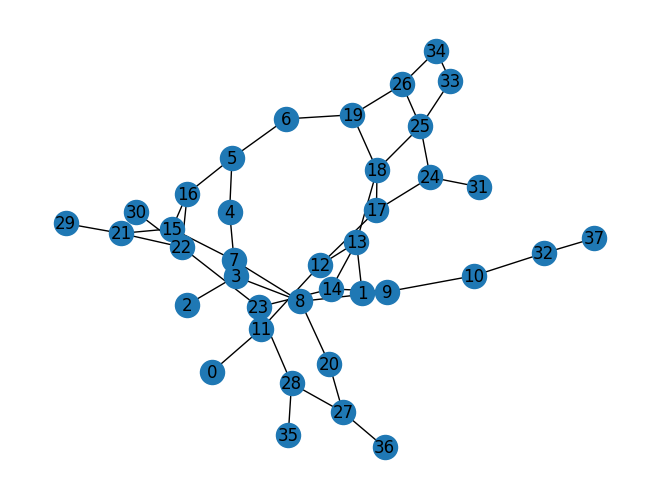

In [2]:

file1 = 'VAIPE_P_TRAIN_0'

data_fd =  "/workspace/nabang1010/LBA_VAIPE/GNN/GNN_Drugnames_Extraction_from_Prescription/data_GNN/"
connect = Grapher(file1, data_fd)

G,result, df1 = connect.graph_formation(export_graph=True)

print(G.nodes)
print(len(G.nodes))

print(df1.shape[0])
df1


In [15]:
import torch 
import torch_geometric
from torch_geometric.utils.convert import from_networkx
from bpemb import BPEmb
from sentence_transformers import SentenceTransformer
import random
import os 
import glob
import numpy as np
import pandas as pd
torch.cuda.empty_cache()

bpemb_en = BPEmb(lang="en", dim=100)
sent_model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens', device='cuda:0')


data_fd =  "/workspace/nabang1010/LBA_VAIPE/GNN/GNN_Drugnames_Extraction_from_Prescription/data_GNN/"

from tqdm import tqdm

def make_sent_bert_features(text):
    emb = sent_model.encode([text])[0]
    return emb

def listdir_nohidden(path):
    file_path_list =  glob.glob(os.path.join(path, '*'))
    # get file name by os.path.basename
    file_name_list = [os.path.basename(file_path) for file_path in file_path_list]
    # remove .csv from file name
    file_name_list = [file_name.split('.')[0] for file_name in file_name_list]
    return file_name_list

def get_data(save_fd):

    path = "/workspace/nabang1010/LBA_VAIPE/GNN/GNN_Drugnames_Extraction_from_Prescription/data_GNN/data_csv_train/"
    
    files = listdir_nohidden(path)

    files.sort()
    all_files = files[1:]

    list_of_graphs = []
    train_list_of_graphs, test_list_of_graphs = [], []

    files = all_files.copy()
    random.shuffle(files)

    training, testing = files[:930], files[930:]

#=======================================================================================================
    for file in tqdm(all_files):

        connect = Grapher(file, data_fd)

        G,_,_ = connect.graph_formation()


        df = connect.relative_distance() 

        individual_data = from_networkx(G)

        feature_cols = ['rd_b', 'rd_r', 'rd_t', 'rd_l','line_number', \
                'n_upper', 'n_alpha', 'n_spaces', 'n_numeric','n_special']

        text_features = np.array(df["Object"].map(make_sent_bert_features).tolist()).astype(np.float32)
        numeric_features = df[feature_cols].values.astype(np.float32)

        features = np.concatenate((numeric_features, text_features), axis=1) 
        features = torch.tensor(features)

        for col in df.columns:
            try:
                df[col] = df[col].str.strip()
            except AttributeError as e:
                pass

        df['labels'] = df['labels'].fillna('undefined')
        df.loc[df['labels'] == 'drugname', 'num_labels'] = 1
        df.loc[df['labels'] == 'quantity', 'num_labels'] = 2
        df.loc[df['labels'] == 'date', 'num_labels'] = 3
        df.loc[df['labels'] == 'usage', 'num_labels'] = 4
        df.loc[df['labels'] == 'diagnose', 'num_labels'] = 5
        # df.loc[df['labels'] == 'undefined', 'num_labels'] = 5
        # fillna df.['num_labels'] by 5
        df['num_labels'] = df['num_labels'].fillna(6)

        assert df['num_labels'].isnull().values.any() == False, f'labeling error! Invalid label(s) present in {file}.csv'
        labels = torch.tensor(df['num_labels'].values.astype(np.int64))
        text = df['Object'].values

        # ****************************************************************************************
        individual_data.x = features
        individual_data.y = labels
        individual_data.text = text
        individual_data.img_id = file

        if file in training:
            train_list_of_graphs.append(individual_data)
        elif file in testing:
            test_list_of_graphs.append(individual_data)
                
    train_data = torch_geometric.data.Batch.from_data_list(train_list_of_graphs)
    train_data.edge_attr = None
    test_data = torch_geometric.data.Batch.from_data_list(test_list_of_graphs)
    test_data.edge_attr = None

    check_exist_folder(save_fd)
    
#=======================================================================================================
    torch.save(train_data, os.path.join(save_fd, 'train_data.dataset'))
    torch.save(test_data, os.path.join(save_fd, 'val_data.dataset'))

save_fd = "/workspace/nabang1010/LBA_VAIPE/GNN/GNN_Drugnames_Extraction_from_Prescription/data_GNN/"
get_data(save_fd=save_fd + "dataset")


  0%|          | 0/1172 [00:00<?, ?it/s]/root/anaconda3/envs/gnn37/lib/python3.7/site-packages/ipykernel_launcher.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 1172/1172 [10:52<00:00,  1.80it/s]


Folder already exist:  /workspace/nabang1010/LBA_VAIPE/GNN/GNN_Drugnames_Extraction_from_Prescription/data_GNN/dataset


In [ ]:
import torch.nn as nn
# import class ChebConv
from torch_geometric.nn import ChebConv
# import class GraphConv
from torch_geometric.nn import GraphConv
# import class GCNConv
from torch_geometric.nn import GCNConv

# import class torch.nn.functional as F
import torch.nn.functional as F


class InvoiceGCN(nn.Module):

    def __init__(self, input_dim, chebnet=False, n_classes=6, dropout_rate=0.2, K=3):
        super().__init__()

        self.input_dim = input_dim
        self.n_classes = n_classes
        self.dropout_rate = dropout_rate

        if chebnet:
            self.conv1 = ChebConv(self.input_dim, 64, K=K)
            self.conv2 = ChebConv(64, 32, K=K)
            self.conv3 = ChebConv(32, 16, K=K)
            self.conv4 = ChebConv(16, self.n_classes, K=K)
        else:
            self.conv1 = GCNConv(self.first_dim, 64, improved=True, cached=True)
            self.conv2 = GCNConv(64, 32, improved=True, cached=True)
            self.conv3 = GCNConv(32, 16, improved=True, cached=True)
            self.conv4 = GCNConv(16, self.n_classes, improved=True, cached=True)

    def forward(self, data):
        # for transductive setting with full-batch update
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr

        x = F.dropout(F.relu(self.conv1(x, edge_index, edge_weight)), p=self.dropout_rate, training=self.training)
        x = F.dropout(F.relu(self.conv2(x, edge_index, edge_weight)), p=self.dropout_rate, training=self.training)
        x = F.dropout(F.relu(self.conv3(x, edge_index, edge_weight)), p=self.dropout_rate, training=self.training)
        x = self.conv4(x, edge_index, edge_weight)

        return F.log_softmax(x, dim=1)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
# import confution matrix
from sklearn.metrics import confusion_matrix
#import clasiification report
from sklearn.metrics import classification_report
import torch

save_fd = "/workspace/nabang1010/LBA_VAIPE/GNN/GNN_Drugnames_Extraction_from_Prescription/data_GNN/processed"
train_data, test_data = torch.load(os.path.join(save_fd, 'train_data.dataset')), torch.load(os.path.join(save_fd, 'test_data.dataset'))

model = InvoiceGCN(input_dim=train_data.x.shape[1], chebnet=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=0.001, weight_decay=0.9
)
train_data = train_data.to(device)
test_data = test_data.to(device)

# class weights for imbalanced data
_class_weights = compute_class_weight(class_weight= "balanced", classes= train_data.y.unique().cpu().numpy(), y = train_data.y.cpu().numpy())
# print(_class_weights)

no_epochs = 2000
for epoch in range(1, no_epochs + 1):
    model.train()
    optimizer.zero_grad()

    # NOTE: just use boolean indexing to filter out test data, and backward after that!
    # the same holds true with test data :D
    # https://github.com/rusty1s/pytorch_geometric/issues/1928
    loss = F.nll_loss(
        model(train_data), train_data.y - 1, weight=torch.FloatTensor(_class_weights).to(device)
    )
    loss.backward()
    optimizer.step()

    # calculate acc on 5 classes
    with torch.no_grad():
        if epoch % 200 == 0:
            model.eval()

            # forward model
            for index, name in enumerate(['train', 'test']):
                _data = eval("{}_data".format(name))
                y_pred = model(_data).max(dim=1)[1]
                y_true = (_data.y - 1)
                acc = y_pred.eq(y_true).sum().item() / y_pred.shape[0]

                y_pred = y_pred.cpu().numpy()
                y_true = y_true.cpu().numpy()
                print("\t{} acc: {}".format(name, acc))
                # confusion matrix
                if name == 'test':
                    cm = confusion_matrix(y_true, y_pred)
                    class_accs = cm.diagonal() / cm.sum(axis=1)
                    print(classification_report(y_true, y_pred))

            loss_val = F.nll_loss(model(test_data), test_data.y - 1
            )
            fmt_log = "Epoch: {:03d}, train_loss:{:.4f}, val_loss:{:.4f}"
            print(fmt_log.format(epoch, loss, loss_val))
            print(">" * 50)


# ****************************************************************************************
# save jtit model


In [ ]:
# import tqdm in notebook
from tqdm import tqdm
import time 
# import Counter
from collections import Counter
import cv2
import matplotlib.pyplot as plt
import shutil
from torch_geometric.utils.convert import from_networkx



img_fd = "/workspace/nabang1010/LBA_VAIPE/GNN/GNN_Drugnames_Extraction_from_Prescription/data_GNN/data_image_train"
test_output_fd = "/workspace/nabang1010/LBA_VAIPE/GNN/GNN_Drugnames_Extraction_from_Prescription/data_GNN/output_folder"

# shutil.rmtree(test_output_fd)
if not os.path.exists(test_output_fd):
    os.mkdir(test_output_fd)
    print("Hello")

def make_info(img_id):
    connect = Grapher(img_id, data_fd)
    G, _, _ = connect.graph_formation()
    df = connect.relative_distance()
    individual_data = from_networkx(G)
    print("################################################################")
    # print(img_fd + img_id + ".png")
    print("################################################################")
    # read image png to ipg

    img = cv2.imread(os.path.join(img_fd, "{}.png".format(img_id)))
    # print(img)
    # img = cv2.imread(os.path.join(img_fd, "{}.png".format(img_id)))[:, :, ::-1]


    return G, df, individual_data, img

y_preds = model(train_data).max(dim=1)[1].cpu().numpy()
LABELS = ["drugname", "quantity", "date", "usage", "diagnose","other"]
test_batch = train_data.batch.cpu().numpy()
indexes = range(len(train_data.img_id))
for index in tqdm(indexes):
    start = time.time()
    img_id = train_data.img_id[index]  # not ordering by img_id
    sample_indexes = np.where(test_batch == index)[0]
    y_pred = y_preds[sample_indexes]

    print("Img index: {}".format(index))
    print("Img id: {}".format(img_id))
    print("y_pred: {}".format(Counter(y_pred)))
    G, df, individual_data, img = make_info(img_id)

    print(df.shape[0])
    print(len(y_pred))

    # assert len(y_pred) == df.shape[0]
    if len(y_pred) != df.shape[0]:
        print("Error")
        continue

    img2 = np.copy(img)
    for row_index, row in df.iterrows():
        x1, y1, x2, y2 = row[['xmin', 'ymin', 'xmax', 'ymax']]
        true_label = row["labels"]

        if isinstance(true_label, str) and true_label != "invoice":
            cv2.rectangle(img2, (x1, y1), (x2, y2), (0, 255, 0), 2)

        _y_pred = y_pred[row_index]
        if _y_pred != 4:
            cv2.rectangle(img2, (x1, y1), (x2, y2), (255, 0, 0), 3)
            _label = LABELS[_y_pred]
            cv2.putText(
                img2, "{}".format(_label), (x1, y1),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2
            )

    check_exist_folder(test_output_fd)
    end = time.time()
    print("\tImage {}: {}".format(img_id, end - start))
    plt.imshow(img2)
    cv2.imwrite(os.path.join(test_output_fd, '{}.jpg'.format(img_id)), img2)


    # plt.savefig(os.path.join(test_output_fd, '{}_result.png'.format(img_id)), bbox_inches='tight')
    # plt.savefig('{}_result.png'.format(img_id), bbox_inches='tight')

# /home/long/Desktop/TestInProject/data_vaipe/public_test/prescription/image/VAIPE_P_TEST_10.png
# /home/long/Desktop/TestInProject/data_vaipe/public_test/prescription/image/VAIPE_P_TRAIN_10.png

In [ ]:

def make_info(img_id):
    connect = Grapher(img_id, data_fd)
    G, _, _ = connect.graph_formation()
    df = connect.relative_distance()
    individual_data = from_networkx(G)
    print("################################################################")
    # print(img_fd + img_id + ".png")
    print("################################################################")
    # read image png to ipg

    img = cv2.imread(os.path.join(img_fd, "{}.png".format(img_id)))
    # print(img)
    # img = cv2.imread(os.path.join(img_fd, "{}.png".format(img_id)))[:, :, ::-1]

G, df, individual_data, img = make_info(img_id)
